## Import

In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.8 MB/s eta 0:00:00


In [2]:
# multilabel kfold
!pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# background remover
!pip install rembg[gpu]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 KB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 102.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.

In [6]:
!pip install --ignore-installed Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 81.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rembg 2.0.30 requires pillow~=9.3.0, but you have pillow 9.0.0 which is incompatible.


In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import multiprocessing

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingLR
from torch.optim import lr_scheduler
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import skimage.transform as transform
import skimage.io as io
import torchvision.models as models
import timm

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

from pathlib import Path
from rembg import remove, new_session

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
CFG = {
    'IMG_SIZE':228,
    'EPOCHS':30,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':64,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load

In [ ]:
%%shell
cd /content/drive/MyDrive/colab_data/4dblock
unzip 4dblock.zip -d /content/

In [21]:
base = './'
os.chdir(base)

In [58]:
df = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [57]:
df.head()

,id,img_path,A,B,C,D,E,F,G,H,I,J
0,TRAIN_00000,./train/TRAIN_00000.jpg,1,0,0,0,0,0,0,0,0,0
1,TRAIN_00001,./train/TRAIN_00001.jpg,1,0,0,0,0,0,0,0,0,0
2,TRAIN_00002,./train/TRAIN_00002.jpg,1,0,0,0,0,0,0,0,0,0
3,TRAIN_00003,./train/TRAIN_00003.jpg,1,0,0,0,0,0,0,0,0,0
4,TRAIN_00004,./train/TRAIN_00004.jpg,1,0,0,0,0,0,0,0,0,0


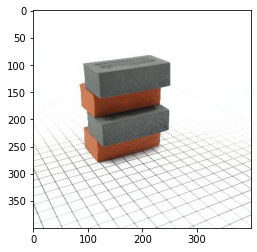

In [71]:
train_img = cv2.imread(df.img_path[100])
train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)
plt.imshow(train_img)

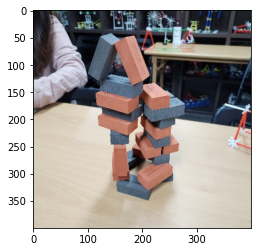

In [69]:
test_img = cv2.imread(test.img_path[100])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

## Train / Validation Split

In [23]:
df2 = df.sample(frac=1)
train_len = int(len(df) * 0.8)

In [24]:
train = df2[:train_len]
val = df2[train_len:]

## Data Preprocessing

### 1. background removal

In [31]:
!mkdir new_data/train

In [ ]:
# remove the background in train data 
session = new_session()

for file in Path('./train/').glob('*.jpg'):
    input_path = str(file)
    output_path = './new_data/'+input_path

    with open(input_path, 'rb') as i:
        with open(output_path, 'wb') as o:
            input = i.read()
            output = remove(input, session=session)
            o.write(output)

In [ ]:
%%shell
rm -r train
mv /content/new_data/train /content/train

### 2. Image download for new background

In [19]:
!mkdir backgrounds

In [ ]:
import requests
from bs4 import BeautifulSoup

if not os.path.exists('images'):
    os.makedirs('images')

url = 'https://unsplash.com/search/photos/background'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
img_tags = soup.find_all('img')

img_urls = []

for img in img_tags:
    img_url = img['src']
    img_urls.append(img_url)

# Download 10000 images
for i in range(10000):
    random_img_url = random.choice(img_urls)
    response = requests.get(random_img_url)
    open(f"backgrounds/image_{i}.jpg", "wb").write(response.content)


### 3. Compose new backgound

In [34]:
def getForegroundMask(foreground):
    mask_new = foreground.copy()[:,:,0]
    mask_new[mask_new>0] = 1
    return mask_new

def compose(foreground, mask, background):
    # resize background
    background = transform.resize(background, foreground.shape[:2])

    # Subtract the foreground area from the background
    background = background*(1 - mask.reshape(foreground.shape[0], foreground.shape[1], 1))

    composed_image = background + foreground
    
    return composed_image

def composenewBG(img):
    mask_new = getForegroundMask(img)
    background_fileName = np.random.choice(os.listdir("./backgrounds/"))
    while background_fileName == '.ipynb_checkpoints':
        background_fileName = np.random.choice(os.listdir("./backgrounds/"))
    background = cv2.imread('./backgrounds/'+background_fileName)/255.0
    image = compose(img, mask_new, background)
    return image


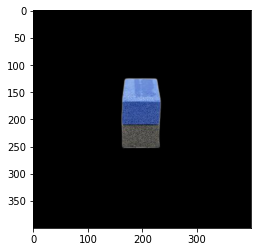

In [39]:
foreground_new = cv2.imread(df.img_path[0])/255.0
plt.imshow(foreground_new)

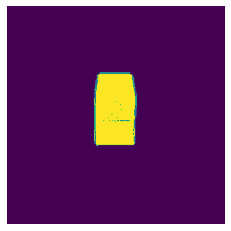

In [40]:
mask_new = getForegroundMask(foreground_new)
plt.imshow(mask_new)
plt.axis('off')
plt.show()

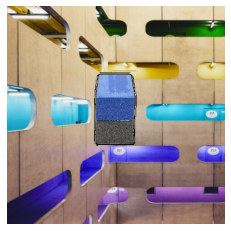

In [41]:
background_fileName = np.random.choice(os.listdir("./backgrounds/"))
while background_fileName == '.ipynb_checkpoints':
    background_fileName = np.random.choice(os.listdir("./backgrounds/"))
background = cv2.imread('./backgrounds/'+background_fileName)/255.0

composed_image = compose(foreground_new, mask_new, background)
plt.imshow(composed_image)
plt.axis('off')
plt.show()

In [ ]:
# Apply to full train data

for file in Path('./train/').glob('*.jpg'):
    path = str(file)
    img = cv2.imread(path)/255.0
    try:
        img = composenewBG(img)*255
    except:
        pass
    cv2.imwrite(path, img)

### Get labels for KFOLD

In [42]:
def get_labels(df):
    return df.iloc[:,2:].values

In [43]:
all_labels = get_labels(df)
train_labels = get_labels(train)
val_labels = get_labels(val)

## CustomDataset

In [44]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = torch.FloatTensor(self.label_list[index])
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [45]:
# augmentations
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5), # 이미지 좌우반전
                            A.RandomBrightnessContrast(p=0.3),
                            #A.Cutout(num_holes=1, max_h_size=100, max_w_size=100, p=1),
                            A.Perspective(p=0.5),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            ToTensorV2()
                            ])

In [46]:
# dataset for NO FOLD
train_dataset = CustomDataset(train['img_path'].values, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=multiprocessing.cpu_count() // 2)

val_dataset = CustomDataset(val['img_path'].values, val_labels, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=multiprocessing.cpu_count() // 2)

In [50]:
# dataset for KFOLD
train_transform_dataset = CustomDataset(df['img_path'].values, all_labels, train_transform)
val_transform_dataset = CustomDataset(df['img_path'].values, all_labels, test_transform)

In [51]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=multiprocessing.cpu_count() // 2)

In [52]:
def getDataloader(train_transform_dataset, val_transform_dataset, train_idx, valid_idx, batch_size, num_workers):

    # train_idx에 해당하는 Subset 추출
    train_set = torch.utils.data.Subset(train_transform_dataset,
                                        indices=train_idx)
    # valid_idx에 해당하는 Subset 추출
    val_set   = torch.utils.data.Subset(val_transform_dataset,
                                        indices=valid_idx)
    
    
    train_loader = DataLoader(train_set, 
                              batch_size = batch_size, 
                              shuffle=True, 
                              num_workers=num_workers, 
                              )
    
    val_loader = DataLoader(val_set, 
                            batch_size= batch_size, 
                            shuffle=False, 
                            num_workers=num_workers)
    return train_loader, val_loader

## Model Define

In [47]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        x = F.sigmoid(self.classifier(x))
        return x

### scheduler(CosineAnnealingWarmUpRestarts)

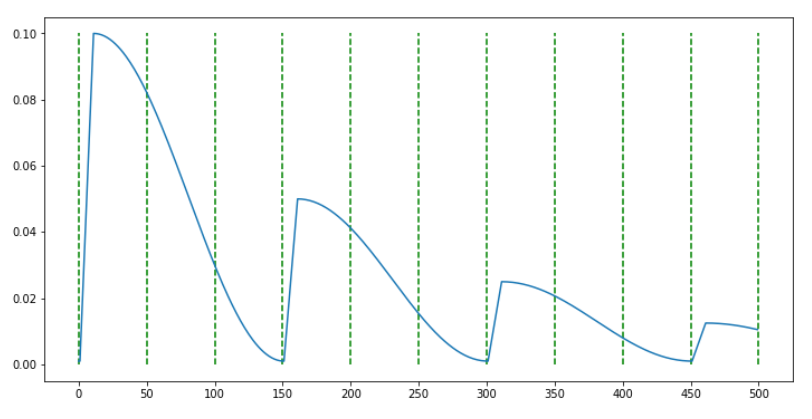

In [ ]:
import math
class CosineAnnealingWarmUpRestarts(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr) * self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (
                        1 + math.cos(math.pi * (self.T_cur - self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch

        self.eta_max = self.base_eta_max * (self.gamma ** self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## Train

In [48]:
model_name = 'resnet50'
RECORDER_DIR = '/content/drive/MyDrive/colab_data/4dblock/weights'

In [49]:
from datetime import datetime, timezone, timedelta
kst = timezone(timedelta(hours=9)) 
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

In [53]:
def train_kfold(device):  
    n_splits = 5  
    kf = MultilabelStratifiedKFold(n_splits=n_splits)
    criterion = nn.BCELoss().to(device)

    patience = 10  
    oof_pred = None
    
    for i, (train_idx, valid_idx) in enumerate(kf.split(df, all_labels)):
        
        num_workers=multiprocessing.cpu_count() // 2
        train_loader, val_loader = getDataloader(train_transform_dataset, val_transform_dataset, train_idx, valid_idx, CFG['BATCH_SIZE'], num_workers)
            
        model = BaseModel()
        model.to(device)
        
        optimizer = torch.optim.Adam(params = model.parameters(), lr = 0)
        scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=1, eta_max=0.001,  T_up=3, gamma=0.5)
        
        best_score = 0
        best_model = None
        counter = 0
        
        for epoch in range(1,CFG["EPOCHS"]+1):
            model.train()
            train_loss = []
            for img, label in tqdm(iter(train_loader)):
                img, label = img.float().to(device), label.to(device)

                optimizer.zero_grad()

                model_pred = model(img)

                loss = criterion(model_pred, label)

                loss.backward()
                optimizer.step()

                train_loss.append(loss.item())

            tr_loss = np.mean(train_loss)

            val_loss, val_score = validation(model, criterion, val_loader, device)

            print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val Acc : [{val_score:.5f}]')

            if scheduler is not None:
                scheduler.step()

            if best_score < val_score:
                best_model = model
                best_score = val_score
                counter=0
                check_point = {                                         
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                }
                torch.save(check_point, os.path.join(RECORDER_DIR,f'{model_name}_best_split_{i}.pt')) 
            else:
                counter+=1
                
            if counter > patience:
                print("Early Stopping...")
                break
           
        all_predictions = []
        with torch.no_grad():
            for images in tqdm(iter(test_loader)):
                
                images = images.float().to(device)
            
                pred = best_model(images) / 2  # 원본 이미지를 예측하고 / 2
                pred += best_model(torch.flip(images, dims=(-1,))) / 2  # horizontal_flip으로 뒤집어 예측하여 앙상블
                pred  = pred.cpu().detach().numpy()
                
                all_predictions.extend(pred)

            fold_pred = np.array(all_predictions)

        # OOF
        if oof_pred is None:
            oof_pred = fold_pred / n_splits
        else:
            oof_pred += fold_pred / n_splits
        
        
        oof_pred_list = []
        if i == n_splits-1:

            # 제출용 csv 생성
            oof_pred = oof_pred > 0.5
            oof_pred_ans = oof_pred.astype(int).tolist()
        
            submit = pd.read_csv('sample_submission.csv')
            submit.iloc[:,1:] = oof_pred_ans
            
            save_answer_path = '/content/drive/MyDrive/colab_data/4dblock/submits/35th_effb0_bg_5fold.csv'
            submit.to_csv(save_answer_path, index=False)

            print(f"Inference Done! Inference result saved at {save_answer_path}")

In [54]:
def train_nofold(device):

    criterion = nn.BCELoss().to(device)
    
    patience = 10
        
    num_workers=multiprocessing.cpu_count() // 2
        
    model = BaseModel()
    model.to(device)
    
    optimizer = torch.optim.Adam(params = model.parameters(), lr = 0)
    scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=1, eta_max=0.001,  T_up=3, gamma=0.5)
    
    best_score = 0
    best_model = None
    counter = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.to(device)

            optimizer.zero_grad()

            model_pred = model(img)

            loss = criterion(model_pred, label)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        tr_loss = np.mean(train_loss)

        val_loss, val_score = validation(model, criterion, val_loader, device)

        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val Acc : [{val_score:.5f}]')

        if scheduler is not None:
            scheduler.step()

        if best_score < val_score:
            best_model = model
            best_score = val_score
            counter=0
            check_point = {                                         
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            }
            torch.save(check_point, os.path.join(RECORDER_DIR,f'{model_name}_best_34.pt')) 
        else:
            counter+=1
            
        if counter > patience:
            print("Early Stopping...")
            break
        
    all_predictions = []
    with torch.no_grad():
        for images in tqdm(iter(test_loader)):
            
            images = images.float().to(device)
        
            pred = best_model(images) / 2  # 원본 이미지를 예측하고 /2
            pred += best_model(torch.flip(images, dims=(-1,))) / 2  # horizontal_flip으로 뒤집어 예측하여 앙상블
            pred  = pred.cpu().detach().numpy()
            
            all_predictions.extend(pred)

        all_predictions = np.array(all_predictions)


        # 제출용 csv 생성
        all_predictions = all_predictions > 0.5
        all_predictions = all_predictions.astype(int).tolist()
    
        submit = pd.read_csv('sample_submission.csv')
        submit.iloc[:,1:] = all_predictions
        
        save_answer_path = '/content/drive/MyDrive/colab_data/4dblock/submits/34th_res50_bg_nofold.csv'
        submit.to_csv(save_answer_path, index=False)
        
        print(f"Inference Done! Inference result saved at {save_answer_path}")

In [55]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    val_acc = []
    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            probs = model(imgs)
            
            loss = criterion(probs, labels)
            
            probs  = probs.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            preds = probs > 0.5
            batch_acc = (labels == preds).mean()
            
            val_acc.append(batch_acc)
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_acc = np.mean(val_acc)
    
    return _val_loss, _val_acc

## Run!!

In [ ]:
# 메모리 관리
torch.cuda.empty_cache()
import gc
gc.collect()

4449

In [ ]:
# 프로젝트 진행은 fold 없이 score를 확인해가면서 진행하고 최종제출은 kfold로 진행
# Train NO FOLD
model = BaseModel()

model.eval()

optimizer = torch.optim.Adam(params = model.parameters(), lr = 0)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=1, eta_max=0.001,  T_up=3, gamma=0.5)
train_nofold(device)

In [ ]:
# Train KFOLD
model = BaseModel()

model.eval()

optimizer = torch.optim.Adam(params = model.parameters(), lr = 0)
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=1, eta_max=0.001,  T_up=3, gamma=0.5)
train_kfold(device)

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.80582] Val Loss : [0.81364] Val Acc : [0.49009]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.30849] Val Loss : [0.23649] Val Acc : [0.89807]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.20796] Val Loss : [0.18379] Val Acc : [0.92050]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.18784] Val Loss : [0.18613] Val Acc : [0.92153]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.15304] Val Loss : [0.15367] Val Acc : [0.93371]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.12493] Val Loss : [0.12360] Val Acc : [0.94564]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10585] Val Loss : [0.10886] Val Acc : [0.94910]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.08435] Val Loss : [0.09798] Val Acc : [0.95468]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.06926] Val Loss : [0.08062] Val Acc : [0.96065]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.05955] Val Loss : [0.07221] Val Acc : [0.96401]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.05598] Val Loss : [0.07217] Val Acc : [0.96417]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.06522] Val Loss : [0.08174] Val Acc : [0.96102]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.08938] Val Loss : [0.10387] Val Acc : [0.95262]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.10621] Val Loss : [0.11778] Val Acc : [0.94728]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.09188] Val Loss : [0.11858] Val Acc : [0.94703]


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.79179] Val Loss : [0.81045] Val Acc : [0.49745]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.30473] Val Loss : [0.18950] Val Acc : [0.91661]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.20536] Val Loss : [0.19136] Val Acc : [0.91919]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.18671] Val Loss : [0.19421] Val Acc : [0.91827]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.15189] Val Loss : [0.17828] Val Acc : [0.92415]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.12687] Val Loss : [0.13055] Val Acc : [0.94230]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10625] Val Loss : [0.11684] Val Acc : [0.94752]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.08802] Val Loss : [0.09083] Val Acc : [0.95748]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.07006] Val Loss : [0.07788] Val Acc : [0.96164]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.05982] Val Loss : [0.06984] Val Acc : [0.96515]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.05733] Val Loss : [0.06922] Val Acc : [0.96523]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.06537] Val Loss : [0.07933] Val Acc : [0.96118]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.08775] Val Loss : [0.09097] Val Acc : [0.95765]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.10687] Val Loss : [0.10022] Val Acc : [0.95427]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.09276] Val Loss : [0.10916] Val Acc : [0.95296]


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.77442] Val Loss : [0.78070] Val Acc : [0.49942]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.31022] Val Loss : [0.23983] Val Acc : [0.89975]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.20598] Val Loss : [0.21894] Val Acc : [0.90676]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.18870] Val Loss : [0.17775] Val Acc : [0.92330]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.15062] Val Loss : [0.15069] Val Acc : [0.93359]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.12969] Val Loss : [0.14243] Val Acc : [0.93815]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10601] Val Loss : [0.11137] Val Acc : [0.94841]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.08739] Val Loss : [0.08779] Val Acc : [0.95710]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.07085] Val Loss : [0.07516] Val Acc : [0.96236]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.06079] Val Loss : [0.06910] Val Acc : [0.96521]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.05719] Val Loss : [0.06918] Val Acc : [0.96518]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.06580] Val Loss : [0.07744] Val Acc : [0.96183]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.08952] Val Loss : [0.09367] Val Acc : [0.95572]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.10586] Val Loss : [0.11509] Val Acc : [0.94997]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.09643] Val Loss : [0.10191] Val Acc : [0.95369]


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.80626] Val Loss : [0.81746] Val Acc : [0.48663]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.30608] Val Loss : [0.21891] Val Acc : [0.90267]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.20371] Val Loss : [0.20281] Val Acc : [0.91124]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.18667] Val Loss : [0.19223] Val Acc : [0.91580]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.15057] Val Loss : [0.16544] Val Acc : [0.92517]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.12754] Val Loss : [0.12495] Val Acc : [0.94280]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10384] Val Loss : [0.10991] Val Acc : [0.94815]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.08405] Val Loss : [0.10318] Val Acc : [0.95237]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.06862] Val Loss : [0.07437] Val Acc : [0.96246]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.05885] Val Loss : [0.06926] Val Acc : [0.96419]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.05636] Val Loss : [0.06946] Val Acc : [0.96412]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.06491] Val Loss : [0.07493] Val Acc : [0.96253]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.08745] Val Loss : [0.09809] Val Acc : [0.95380]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.10545] Val Loss : [0.10704] Val Acc : [0.95075]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.09194] Val Loss : [0.09568] Val Acc : [0.95494]


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.78730] Val Loss : [0.78991] Val Acc : [0.50853]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.29704] Val Loss : [0.19070] Val Acc : [0.91635]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.20477] Val Loss : [0.19106] Val Acc : [0.91544]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.18510] Val Loss : [0.21272] Val Acc : [0.91152]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.14895] Val Loss : [0.14585] Val Acc : [0.93504]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.12703] Val Loss : [0.13469] Val Acc : [0.94129]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.10511] Val Loss : [0.12543] Val Acc : [0.94617]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.08360] Val Loss : [0.08840] Val Acc : [0.95754]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.07011] Val Loss : [0.08125] Val Acc : [0.96101]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.05907] Val Loss : [0.07309] Val Acc : [0.96438]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.05669] Val Loss : [0.07300] Val Acc : [0.96411]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.06531] Val Loss : [0.07969] Val Acc : [0.96235]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.08823] Val Loss : [0.09626] Val Acc : [0.95538]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.10488] Val Loss : [0.12601] Val Acc : [0.94542]


  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.09128] Val Loss : [0.10327] Val Acc : [0.95221]


  0%|          | 0/23 [00:00<?, ?it/s]

Inference Done! Inference result saved at /content/drive/MyDrive/colab_data/4dblock/submits/35th_effb0_bg_5fold.csv


In [ ]:
# 완료되면 세션 종료
from google.colab import runtime
runtime.unassign()

## + Inference & Submission

In [ ]:
# 다른 weight로 추가 inference가 필요할시
best_models = ['res50bg_best_34',
               
               ]
n_splits = 1
oof_pred = None

In [ ]:
for i, emodel in enumerate(best_models):
    best_model = BaseModel()
    best_model.to(device)
    best_model.eval()
    checkpoint = torch.load(f'/content/drive/MyDrive/colab_data/4dblock/weights/{emodel}.pt')
    best_model.load_state_dict(checkpoint['model'])


    all_predictions = []
    with torch.no_grad():
        for images in tqdm(iter(test_loader)):
            
            images = images.float().to(device)
        
            pred = best_model(images) / 2  
            pred += best_model(torch.flip(images, dims=(-1,))) / 2
            pred  = pred.cpu().detach().numpy()
            
            all_predictions.extend(pred)

        fold_pred = np.array(all_predictions)

    # OOF
    if oof_pred is None:
        oof_pred = fold_pred / n_splits
    else:
        oof_pred += fold_pred / n_splits
    
    
    oof_pred_list = []
    if i == n_splits-1:

        # 제출용 csv 생성
        oof_pred = oof_pred > 0.5
        oof_pred_ans = oof_pred.astype(int).tolist()
    
        submit = pd.read_csv('sample_submission.csv')
        submit.iloc[:,1:] = oof_pred_ans
        
        save_answer_path = '/content/drive/MyDrive/colab_data/4dblock/submits/34th_res50_bg.csv'
        submit.to_csv(save_answer_path, index=False)

        print(f"Inference Done! Inference result saved at {save_answer_path}")

  0%|          | 0/92 [00:00<?, ?it/s]

Inference Done! Inference result saved at /content/drive/MyDrive/colab_data/4dblock/submits/34th_res50_bg.csv
